In this document, I will ananlyse feature contribution matrix and survey data using heat map and cosine similarity

In [17]:
from __future__ import division
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
import seaborn as sns

from code.organize import *
from code.roughEDA import *
from code.survey_processor_full import *
from code.model_vis import *
from code.fc_cluster import *
from code.fc import *

from sklearn.preprocessing import scale

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Feature contribution matrix

In [4]:
fc = FeatureContribution('data/fc_df2.pkl')
fc_df = fc.cluster_processor(3,6)

In [137]:
# groupby cluster, then take means
summary = fc_df.groupby('cluster')[fc.features].agg(np.mean)

#Normalize by columns
summary = pd.DataFrame(scale(summary),columns=fc.features)

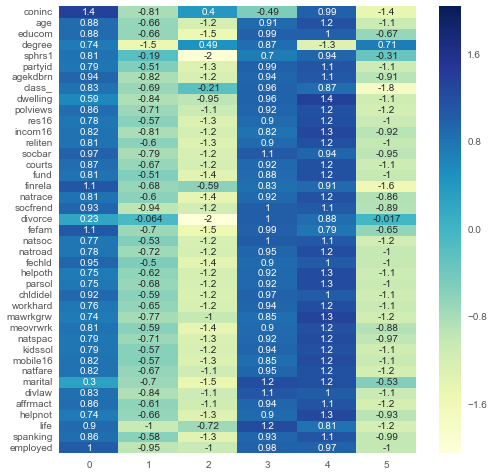

In [140]:
# heat map
plt.figure(figsize=(8,8))
sns.heatmap(summary.T,cmap="YlGnBu",annot=True)

In [104]:
# Check cosine similarity
cos_dict = df_cosine_dist(summary.T)
cos_dict

OrderedDict([((0, 3), 0.08),
             ((0, 4), 0.09),
             ((3, 4), 0.09),
             ((1, 5), 0.13),
             ((2, 5), 0.16),
             ((1, 2), 0.2),
             ((1, 4), 1.83),
             ((0, 2), 1.87),
             ((3, 5), 1.88),
             ((1, 3), 1.92),
             ((2, 4), 1.94),
             ((0, 5), 1.94),
             ((2, 3), 1.94),
             ((0, 1), 1.95),
             ((4, 5), 1.96)])

#### First 6 pairs are from same employed groups, because they have gone through same decision tree path which is consistant with random forest results. 

### However, the ranking of cosine similarity across employed groups, gives us some insight on how similar between blusters and which features result in different employment status.

In [141]:
# anking of cosine similarity across employed groups
list(cos_dict.iteritems())[6]

((1, 4), 1.83)

In [142]:
list(cos_dict.iteritems())[-1]

((4, 5), 1.96)

According to the paired cosine similarity result. Unemployed cluster 1 and employed cluster 4 are most similar across employed groups. Also, amongest the unployed group, cluster 1 has more "blue" colors which indicates that they are closer to the employed group. 

On the other hand, cluster 4 and cluster 5 differs the most. 

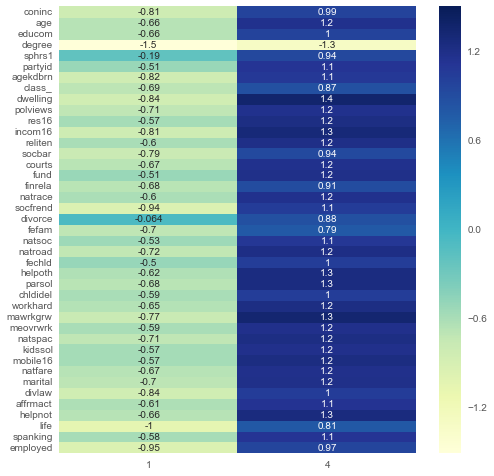

In [154]:

plt.figure(figsize=(8,8))
sns.heatmap(summary.ix[[1,4]].T,cmap="YlGnBu",annot=True)

In [157]:
summary.ix[4]-summary.ix[1]

coninc      1.799258
age         1.822911
educom      1.654676
degree      0.198860
sphrs1      1.132171
partyid     1.631635
agekdbrn    1.909105
class_      1.566434
dwelling    2.197445
polviews    1.887451
res16       1.800427
incom16     2.108242
reliten     1.806825
socbar      1.725205
courts      1.838120
fund        1.705704
finrela     1.582167
natrace     1.762950
socfrend    1.997544
divorce     0.939554
fefam       1.499478
natsoc      1.631009
natroad     1.944297
fechld      1.540023
helpoth     1.879747
parsol      1.930740
chldidel    1.633293
workhard    1.871037
mawrkgrw    2.109365
meovrwrk    1.771906
natspac     1.932244
kidssol     1.748497
mobile16    1.805869
natfare     1.844239
marital     1.895963
divlaw      1.890056
affrmact    1.747142
helpnot     1.920771
life        1.848791
spanking    1.700376
employed    1.921959
dtype: float64